<a href="https://colab.research.google.com/github/kridtapon/Triangular-Moving-Average-Crossover-Heatmap/blob/main/Triangular_Moving_Average_Crossover_Heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.4/527.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstal

[*********************100%***********************]  1 of 1 completed


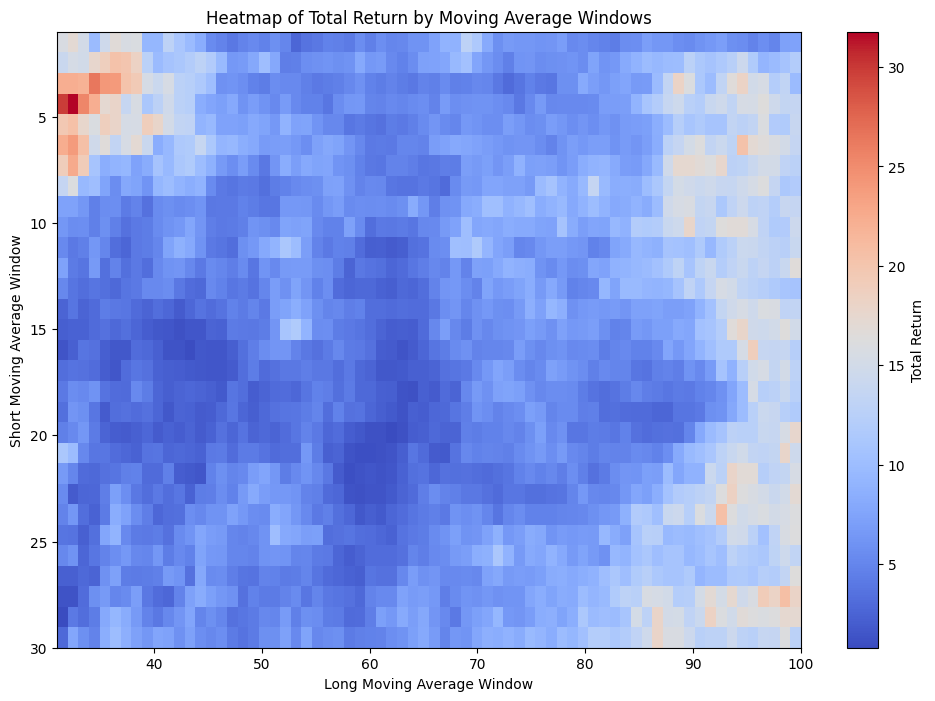

Best Short Window: 4
Best Long Window: 32
Best Performance: 3178.00%


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Calculate triangular moving averages
def calculate_triangular_moving_averages(df, short_window, long_window):
    """Calculate short-term and long-term triangular moving averages."""
    df['Short_TMA'] = df['Close'].rolling(window=short_window).apply(lambda x: np.mean(np.cumsum(x) / range(1, len(x) + 1)), raw=True)
    df['Long_TMA'] = df['Close'].rolling(window=long_window).apply(lambda x: np.mean(np.cumsum(x) / range(1, len(x) + 1)), raw=True)
    return df

# Define the stock symbol and time period
symbol = 'TSLA'
start_date = '2014-12-25'
end_date = '2024-12-25'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Optimization range for moving average windows
short_window_range = range(1, 31)  # Example: 5 to 30
long_window_range = range(31, 101)  # Example: 30 to 100

# Initialize heatmap results
heatmap_results = np.full((len(short_window_range), len(long_window_range)), np.nan)

# Perform grid search
for i, short_window in enumerate(short_window_range):
    for j, long_window in enumerate(long_window_range):
        if short_window >= long_window:
            continue  # Skip invalid combinations where short_window >= long_window

        # Calculate triangular moving averages
        temp_df = calculate_triangular_moving_averages(df.copy(), short_window, long_window)

        # Define entry and exit signals
        temp_df['Entry'] = (
            (temp_df['Short_TMA'] > temp_df['Long_TMA']) &
            (temp_df['Short_TMA'].shift(1) <= temp_df['Long_TMA'].shift(1))
        )
        temp_df['Exit'] = (
            (temp_df['Short_TMA'] < temp_df['Long_TMA']) &
            (temp_df['Short_TMA'].shift(1) >= temp_df['Long_TMA'].shift(1))
        )

        # Backtest using vectorbt
        portfolio = vbt.Portfolio.from_signals(
            close=temp_df['Close'],
            entries=temp_df['Entry'].to_numpy(),
            exits=temp_df['Exit'].to_numpy(),
            init_cash=100_000,
            fees=0.001
        )

        # Store performance in heatmap
        performance = portfolio.total_return()
        heatmap_results[i, j] = performance

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(
    heatmap_results,
    cmap='coolwarm',
    interpolation='nearest',
    extent=[
        long_window_range.start,
        long_window_range.stop - 1,
        short_window_range.stop - 1,
        short_window_range.start,
    ],
    aspect='auto',
)
plt.colorbar(label='Total Return')
plt.title('Heatmap of Total Return by Moving Average Windows')
plt.xlabel('Long Moving Average Window')
plt.ylabel('Short Moving Average Window')
plt.show()

# Extract best combination for reference
max_return_idx = np.unravel_index(np.nanargmax(heatmap_results), heatmap_results.shape)
best_short_window = short_window_range.start + max_return_idx[0]
best_long_window = long_window_range.start + max_return_idx[1]

print(f"Best Short Window: {best_short_window}")
print(f"Best Long Window: {best_long_window}")
print(f"Best Performance: {heatmap_results[max_return_idx]:.2%}")


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Calculate triangular moving averages
def calculate_triangular_moving_averages(df, short_window, long_window):
    """Calculate short-term and long-term triangular moving averages."""
    df['Short_TMA'] = df['Close'].rolling(window=short_window).apply(lambda x: np.mean(np.cumsum(x) / range(1, len(x) + 1)), raw=True)
    df['Long_TMA'] = df['Close'].rolling(window=long_window).apply(lambda x: np.mean(np.cumsum(x) / range(1, len(x) + 1)), raw=True)
    return df

# Define the stock symbol and time period
symbol = 'TSLA'
start_date = '2014-12-25'
end_date = '2024-12-25'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate Triangular Moving Averages
df = calculate_triangular_moving_averages(df, short_window=4, long_window=32)

# Define entry and exit signals based on TMA crossover
df['Entry'] = (
    (df['Short_TMA'] > df['Long_TMA']) &  # Short-term TMA crosses above Long-term TMA
    (df['Short_TMA'].shift(1) <= df['Long_TMA'].shift(1))  # Previous Short-term TMA was below Long-term TMA
)

df['Exit'] = (
    (df['Short_TMA'] < df['Long_TMA']) &  # Short-term TMA crosses below Long-term TMA
    (df['Short_TMA'].shift(1) >= df['Long_TMA'].shift(1))  # Previous Short-term TMA was above Long-term TMA
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                         2014-12-26 00:00:00
End                           2024-12-24 00:00:00
Period                                       2516
Start Value                              100000.0
End Value                           3278000.44935
Total Return [%]                      3178.000449
Benchmark Return [%]                  2943.718772
Max Gross Exposure [%]                      100.0
Total Fees Paid                      75459.110697
Max Drawdown [%]                        50.267869
Max Drawdown Duration                       636.0
Total Trades                                   53
Total Closed Trades                            52
Total Open Trades                               1
Open Trade PnL                     1435919.136096
Win Rate [%]                            42.307692
Best Trade [%]                          188.17177
Worst Trade [%]                        -15.446743
Avg Winning Trade [%]                   30.227332
Avg Losing Trade [%]                    -5.778645
